In [2]:
import xgboost as xgb, duckdb as db 
from sklearn.metrics import mean_squared_log_error
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import plot_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from scipy.signal import periodogram
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import plotly.express as pe 
from sklearn.preprocessing import OneHotEncoder
import plotly.graph_objects as go
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

1. Trend 
   1. use moving average to see what kind of trend is seen  

In [3]:
df = pd.read_csv('train.csv')
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['weekofyear'] = df['date'].dt.isocalendar().week
#df = df.query("year>=2016")
#df['date'] = df.date.dt.to_period('D')
df.set_index([
    'date', 'store_nbr','family'
], inplace=True)
df_test = df.query("date>='2017-08-01'")
df_train = df.query("date<'2017-08-01'")

researching multi-seasonality trend decompostion 

seasonal_7  seasonal_364
date                                
2013-01-01 -115.067139  -1125.022497
2013-01-02 -163.903052   1761.891935
2013-01-03 -115.792871    262.573299
2013-01-04 -228.800119    652.372016
2013-01-05  152.491607    652.776598

sales  log_sales        trend  seasonal_7  seasonal_364  \
date                                                                        
2013-01-01    15.000000   2.708050   908.727002 -115.067139  -1125.022497   
2013-01-02  1335.037037   7.196714   910.081531 -163.903052   1761.891935   
2013-01-03   964.907407   6.872032   911.436875 -115.792871    262.573299   
2013-01-04  1003.092593   6.910843   912.793043 -228.800119    652.372016   
2013-01-05  1441.074074   7.273144   914.150046  152.491607    652.776598   
...                 ...        ...          ...         ...           ...   
2017-08-11  3502.055556   8.161105  3860.789200  -19.440453   -122.630986   
2017-08-12  3376.259259   8.124524  3862.896314  377.994547   -421.317049   
2017-08-13  3747.296296   8.228790  3865.003074  844.922995   -667.941363   
2017-08-14  3237.629630   8.082597  3867.109477  -15.068901   -528.236179   
2017-08-15  3162.462963   8.059106  3869.215520  -97.414314   -397.321227   

                  resid   prediction  
date                                  
2013-01-01   346.362634    15.000000  
2013-01-02 -1173.033377  1335.037037  
2013-01-03   -93.309895   964.907407  
2013-01-04  -333.272347  1003.092593  
2013-01-05  -278.344177  1441.074074  
...                 ...          ...  
2017-08-11  -216.662205  3502.055556  
2017-08-12  -443.314552  3376.259259  
2017-08-13  -294.688410  3747.296296  
2017-08-14   -86.174767  3237.629630  
2017-08-15  -212.017015  3162.462963  

[1684 rows x 7 columns]

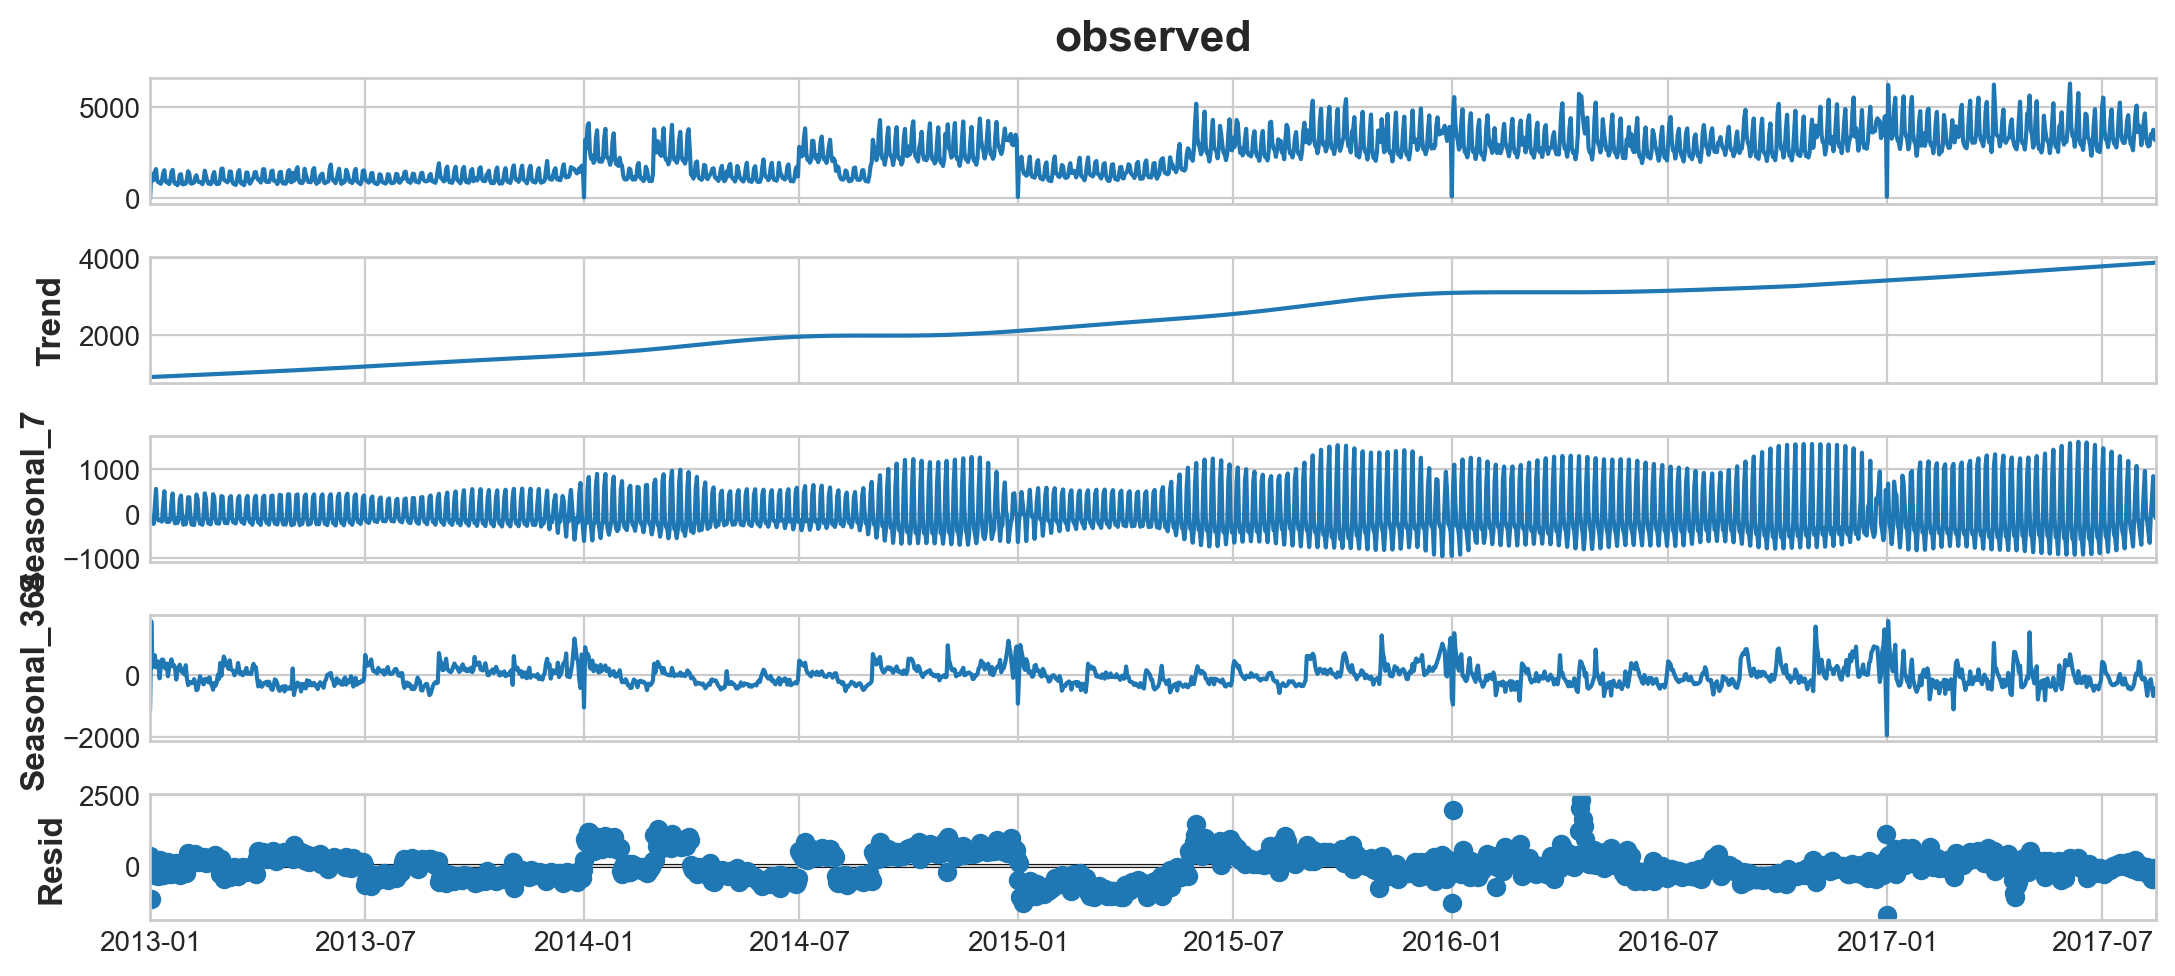

In [4]:
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import DecomposeResult

avg_beverage_sales = df.reset_index().set_index('family').loc['BEVERAGES'].groupby(['date'])['sales'].mean().to_frame()
avg_beverage_sales["log_sales"]= np.log(avg_beverage_sales["sales"])
avg_grocery_sales = df.reset_index().set_index('family').loc['GROCERY I'].groupby(['date'])['sales'].mean().to_frame()
avg_grocery_sales["log_sales"]= np.log(avg_grocery_sales["sales"])
avg_all_sales = df.reset_index().set_index(['date','family']).groupby(['date'])['sales'].mean().to_frame()
#avg_all_sales["log_sales"]= np.log(avg_all_sales["sales"])

mstl = MSTL(avg_beverage_sales['sales'], periods=[7, 7*52])
res = mstl.fit()
display(res.seasonal.head())
ax = res.plot()

#LESSON: prediction = trend + seasonality + residual (random)
df_trend = res.trend.to_frame()
df_seasonality = res.seasonal
df_res = res.resid

verify = avg_beverage_sales.merge(df_trend, on='date', how='left').merge(df_seasonality, on='date', how='left').merge(df_res, on='date', how='left')
verify["prediction"] = verify["trend"] + verify["seasonal_7"] + verify["seasonal_364"] + verify["resid"]
verify
#NOTE: remember we used average of sales

#we see yearly, weekly. so order == 2. 

#quarterly seems a bit week at later stagew but if we use it then order==3. 

Notes: nice to visaulize trends and seasonality. 
Questions: when to use vs DeterministicProcess? 

Trends - researching DeterministicProcess 

df.loc[(df.index.get_level_values('A') > 1.7) & (df.index.get_level_values('B') < 666)]

In [5]:
from statsmodels.tsa.deterministic import DeterministicProcess, Fourier, Seasonality, TimeTrend
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
df = pd.read_csv('train.csv', parse_dates=['date'], dtype={
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
})
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week'] = df['date'].dt.dayofweek
df['day_of_month'] = df['date'].dt.day
df['quarter'] = df['date'].dt.quarter
df['weekofyear'] = df['date'].dt.isocalendar().week
df['date_ordinal'] = df['date'].map(pd.Timestamp.toordinal)
df['sales'] = df['sales'].astype(np.int32)
df = df.set_index('date').to_period('D')
df = df.set_index(['store_nbr','family'], append=True)

average_sales = df.groupby('date').mean()['sales']
average_sales.head(100)

date
2013-01-01      1.407407
2013-01-02    278.328844
2013-01-03    202.781145
2013-01-04    198.847363
2013-01-05    267.807520
                 ...    
2013-04-06    285.815937
2013-04-07    291.214927
2013-04-08    194.474186
2013-04-09    171.850168
2013-04-10    175.503367
Freq: D, Name: sales, Length: 100, dtype: float64

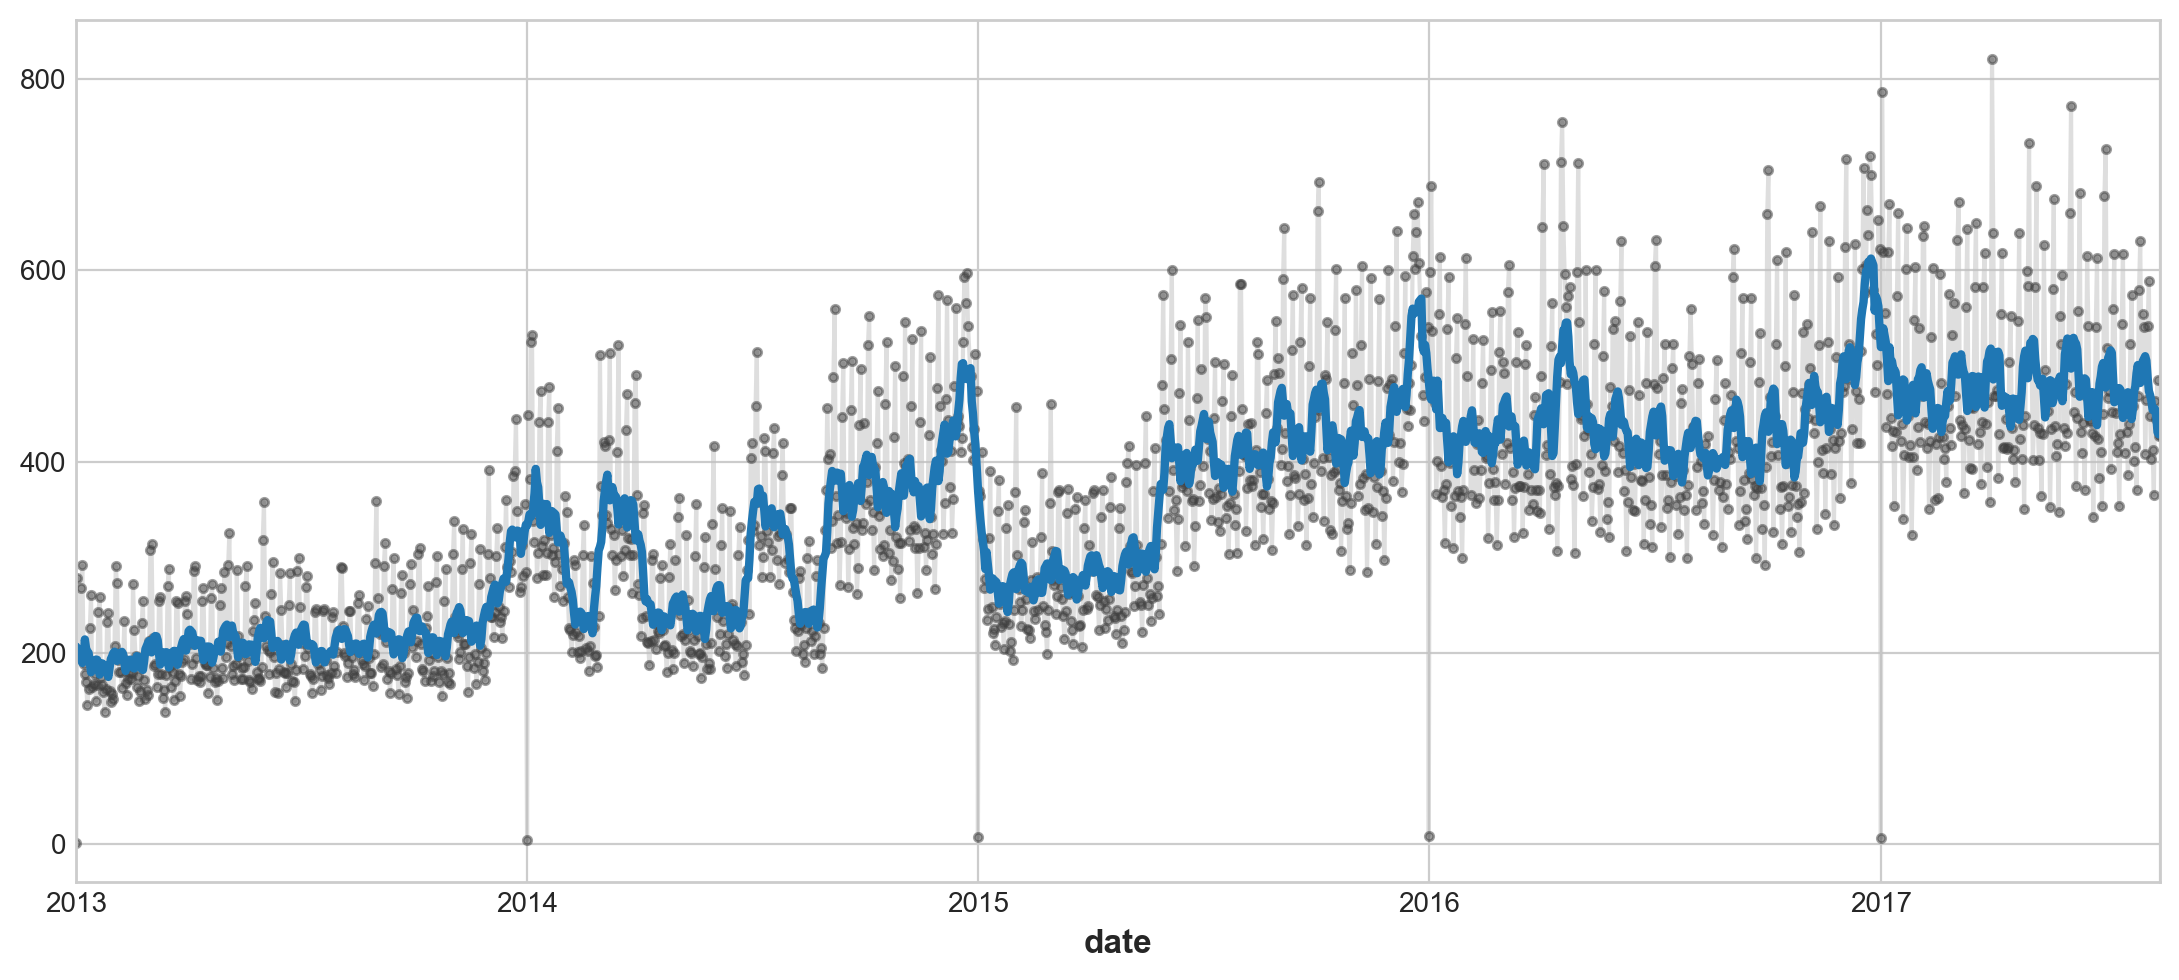

In [6]:
trend = average_sales.rolling(window=12, center=True, min_periods=6).mean()
ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

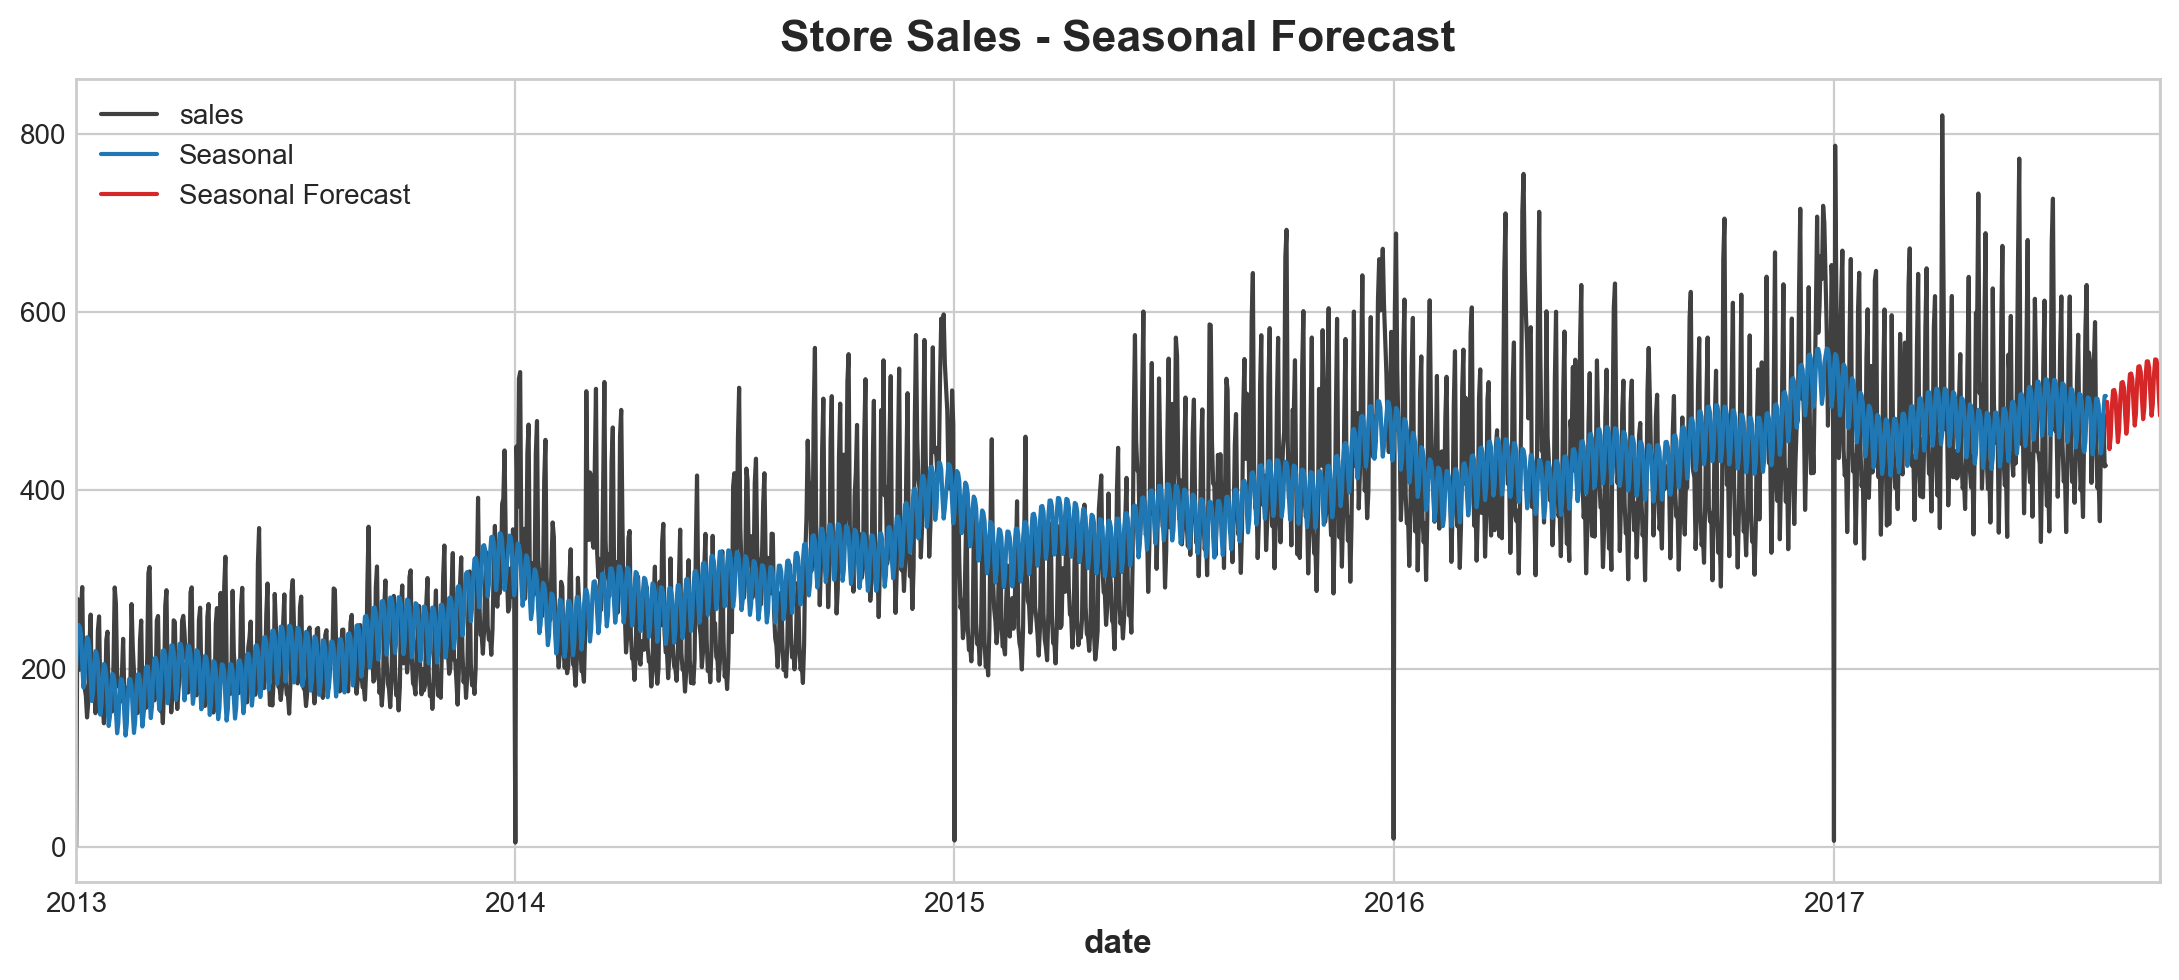

In [7]:
average_sales = df.groupby(['date']).mean()['sales']
y = average_sales
fourier = Fourier(period=365.25, order=4)
weekly_seasonality = Seasonality(period=7)
dp = DeterministicProcess(
    index = y.index,       
    constant= False,
    order = 2,
    additional_terms=[fourier, weekly_seasonality],    
    drop=True
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
average_sales_trend = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
average_sales_trend_forecast = dp.out_of_sample(steps=45)

model = LinearRegression(fit_intercept=False)
_ = model.fit(average_sales_trend,y)

y_pred = pd.Series(model.predict(average_sales_trend), index=y.index)
X_fore = average_sales_trend_forecast
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25',  title="Store Sales - Seasonal Forecast", )
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

#TODO: change the chart to use plotly 

In [8]:
y_fore

2017-08-16    499.409875
2017-08-17    468.960345
2017-08-18    446.344260
2017-08-19    459.512718
2017-08-20    494.263848
2017-08-21    512.138708
2017-08-22    512.736684
2017-08-23    506.506472
2017-08-24    476.443607
2017-08-25    454.185743
2017-08-26    467.682193
2017-08-27    502.729451
2017-08-28    520.867099
2017-08-29    521.693212
2017-08-30    515.655349
2017-08-31    485.748086
2017-09-01    463.608305
2017-09-02    477.184733
2017-09-03    512.273470
2017-09-04    530.413901
2017-09-05    531.204097
2017-09-06    525.091812
2017-09-07    495.072009
2017-09-08    472.782156
2017-09-09    486.171755
2017-09-10    521.037870
2017-09-11    538.921037
2017-09-12    539.420654
2017-09-13    532.985977
2017-09-14    502.613638
2017-09-15    479.942929
2017-09-16    492.925331
2017-09-17    527.360026
2017-09-18    544.789795
2017-09-19    544.816406
2017-09-20    537.891591
2017-09-21    507.014554
2017-09-22    483.827248
2017-09-23    496.283879
2017-09-24    530.186419


Serial dependence -learnt from lag values aka previous known value. cyclic behavior can be much more irregular than seasonality.

Plotting the partial autocorrelation can help you choose which lag features to use. We can use correlogram for this. 

In [9]:
avg_beverage_sales

sales  log_sales
date                              
2013-01-01    15.000000   2.708050
2013-01-02  1335.037037   7.196714
2013-01-03   964.907407   6.872032
2013-01-04  1003.092593   6.910843
2013-01-05  1441.074074   7.273144
...                 ...        ...
2017-08-11  3502.055556   8.161105
2017-08-12  3376.259259   8.124524
2017-08-13  3747.296296   8.228790
2017-08-14  3237.629630   8.082597
2017-08-15  3162.462963   8.059106

[1684 rows x 2 columns]

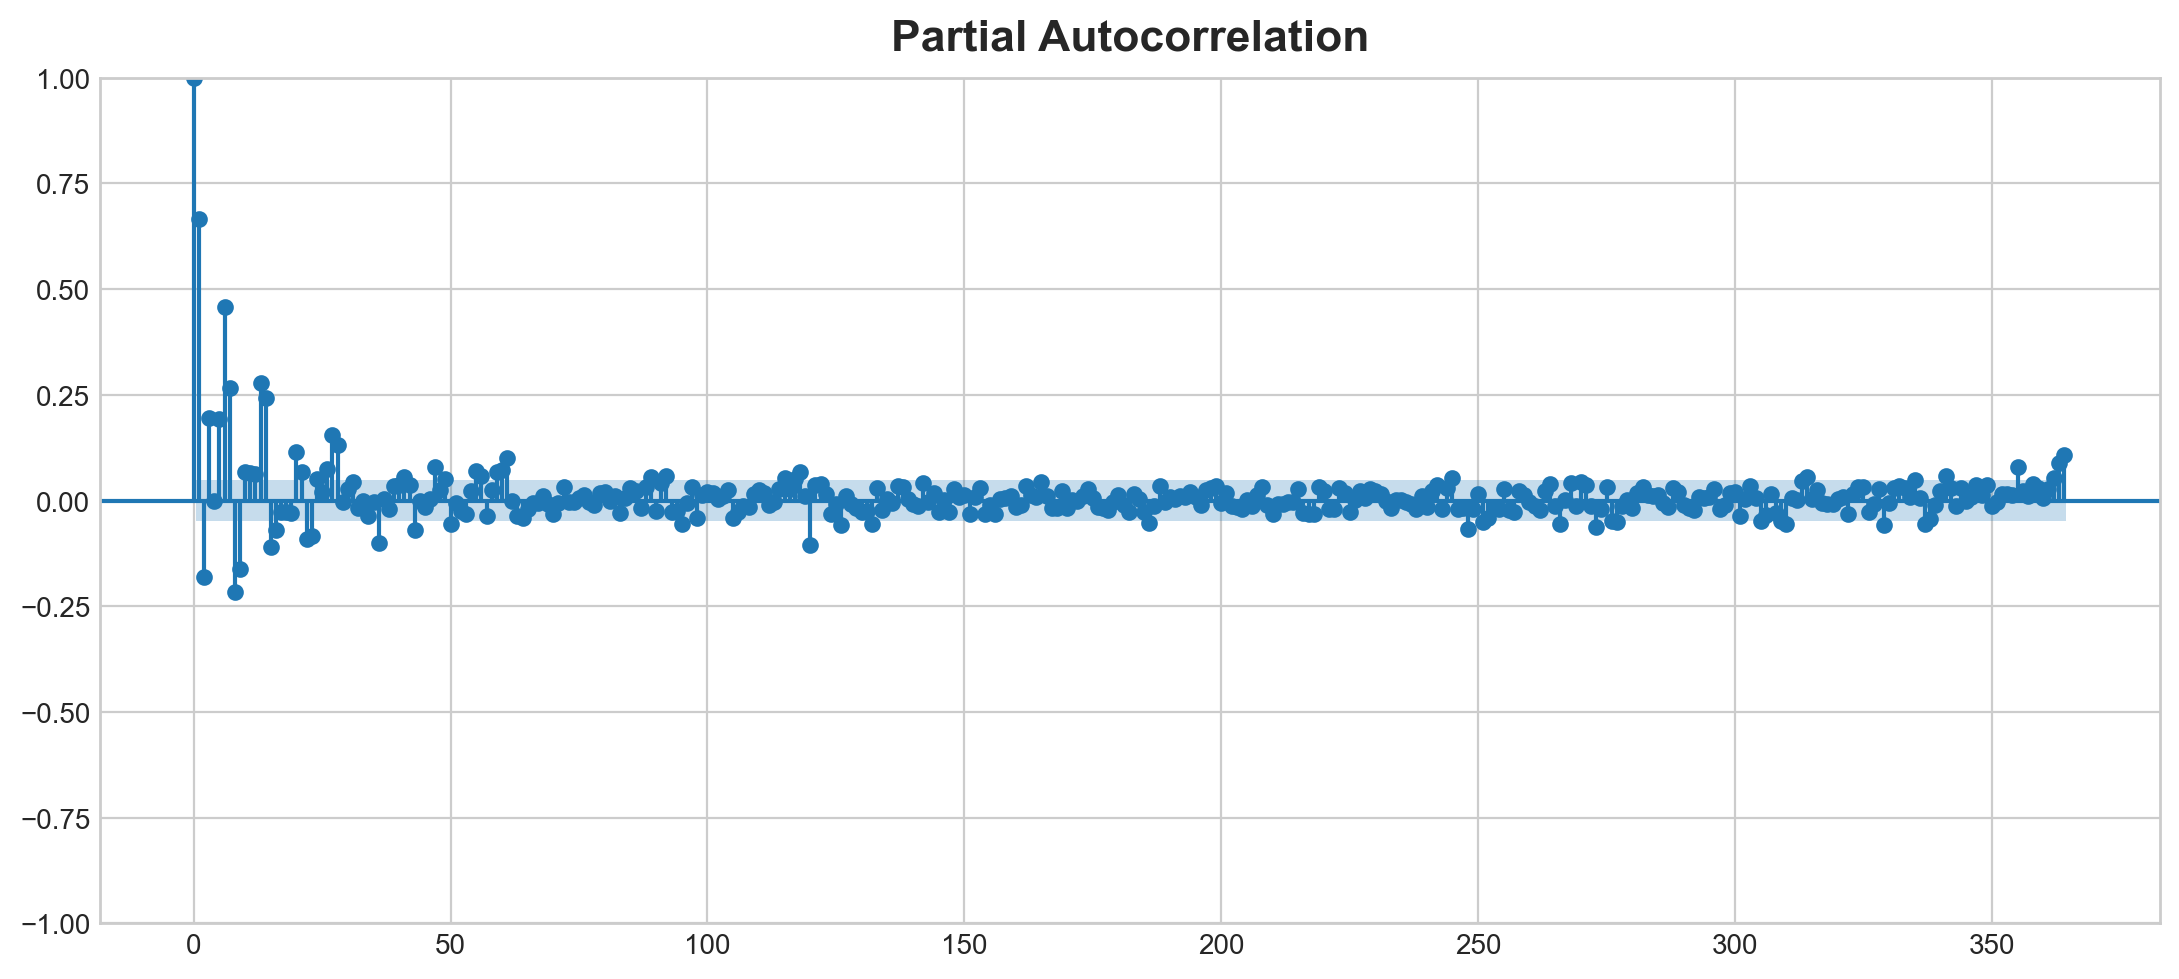

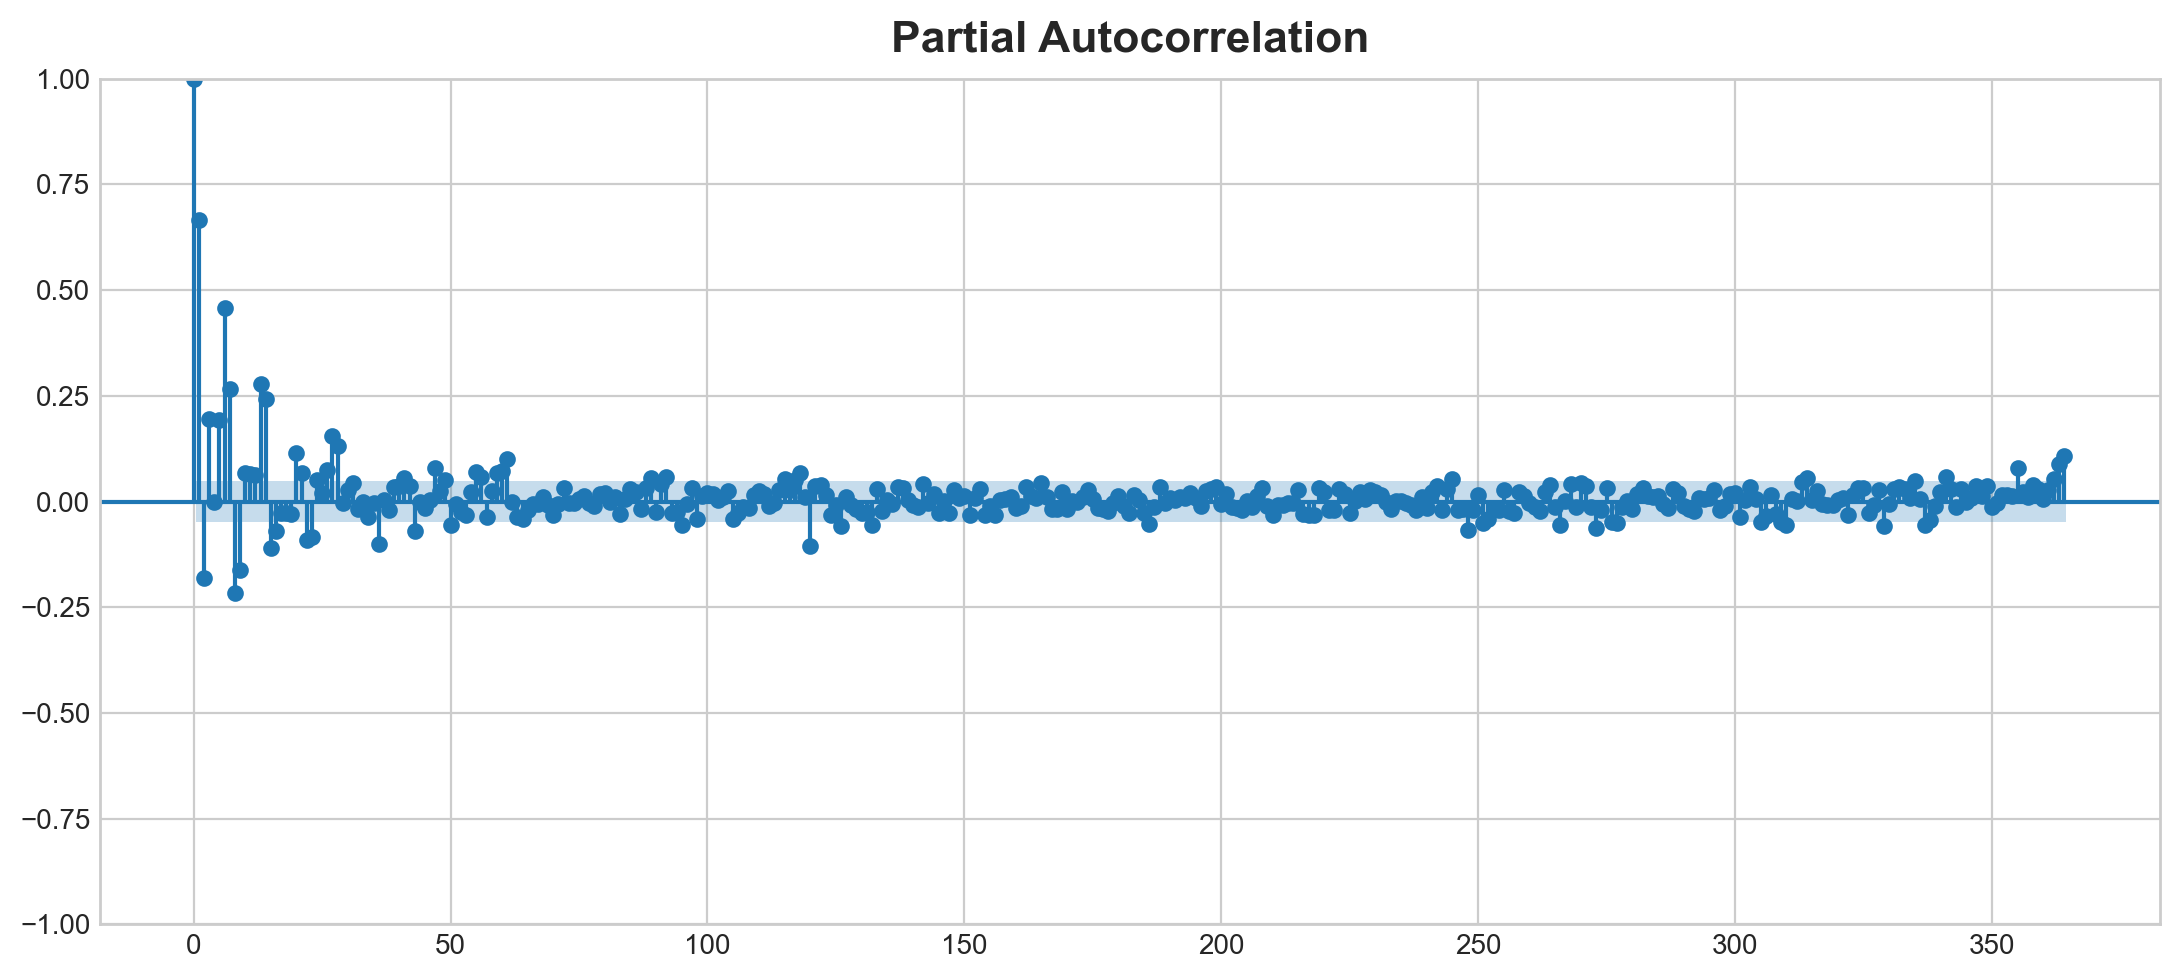

In [12]:
plot_pacf(avg_grocery_sales["sales"] , lags=364)

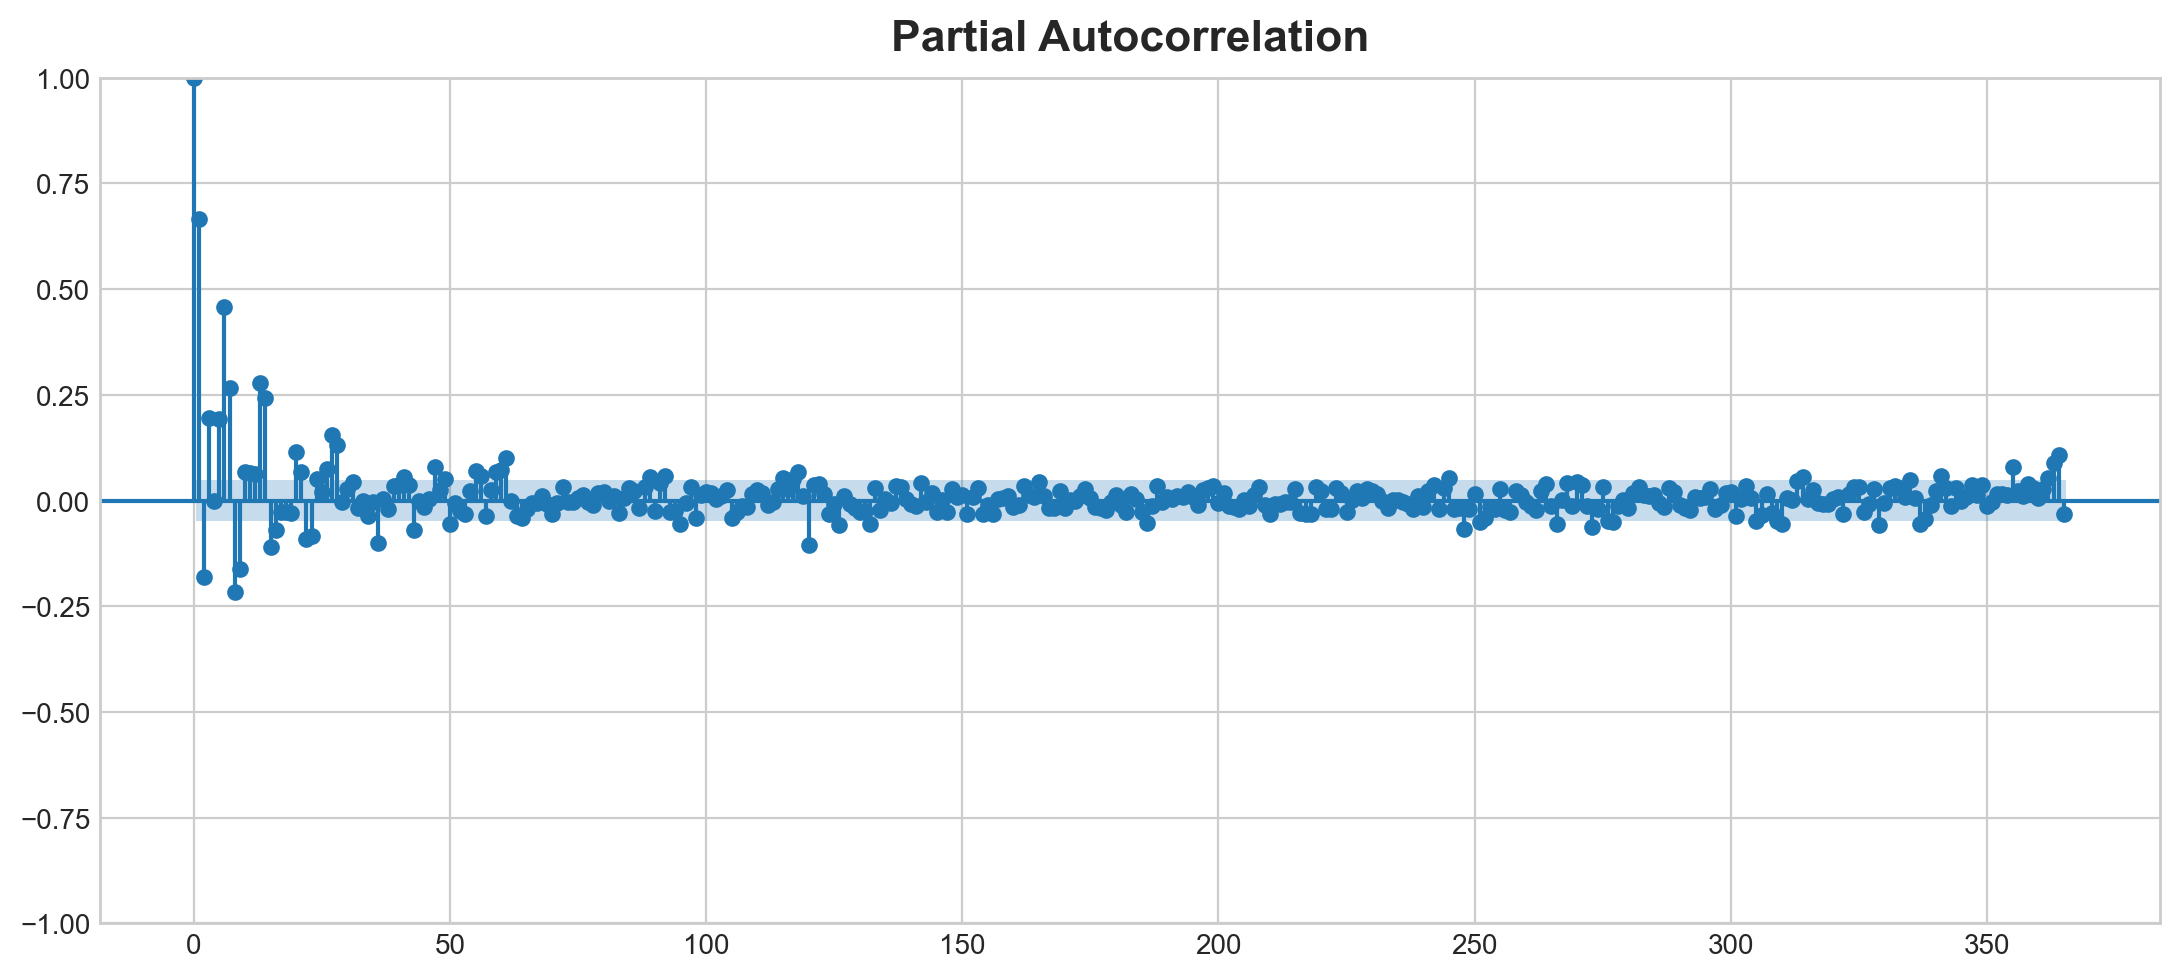

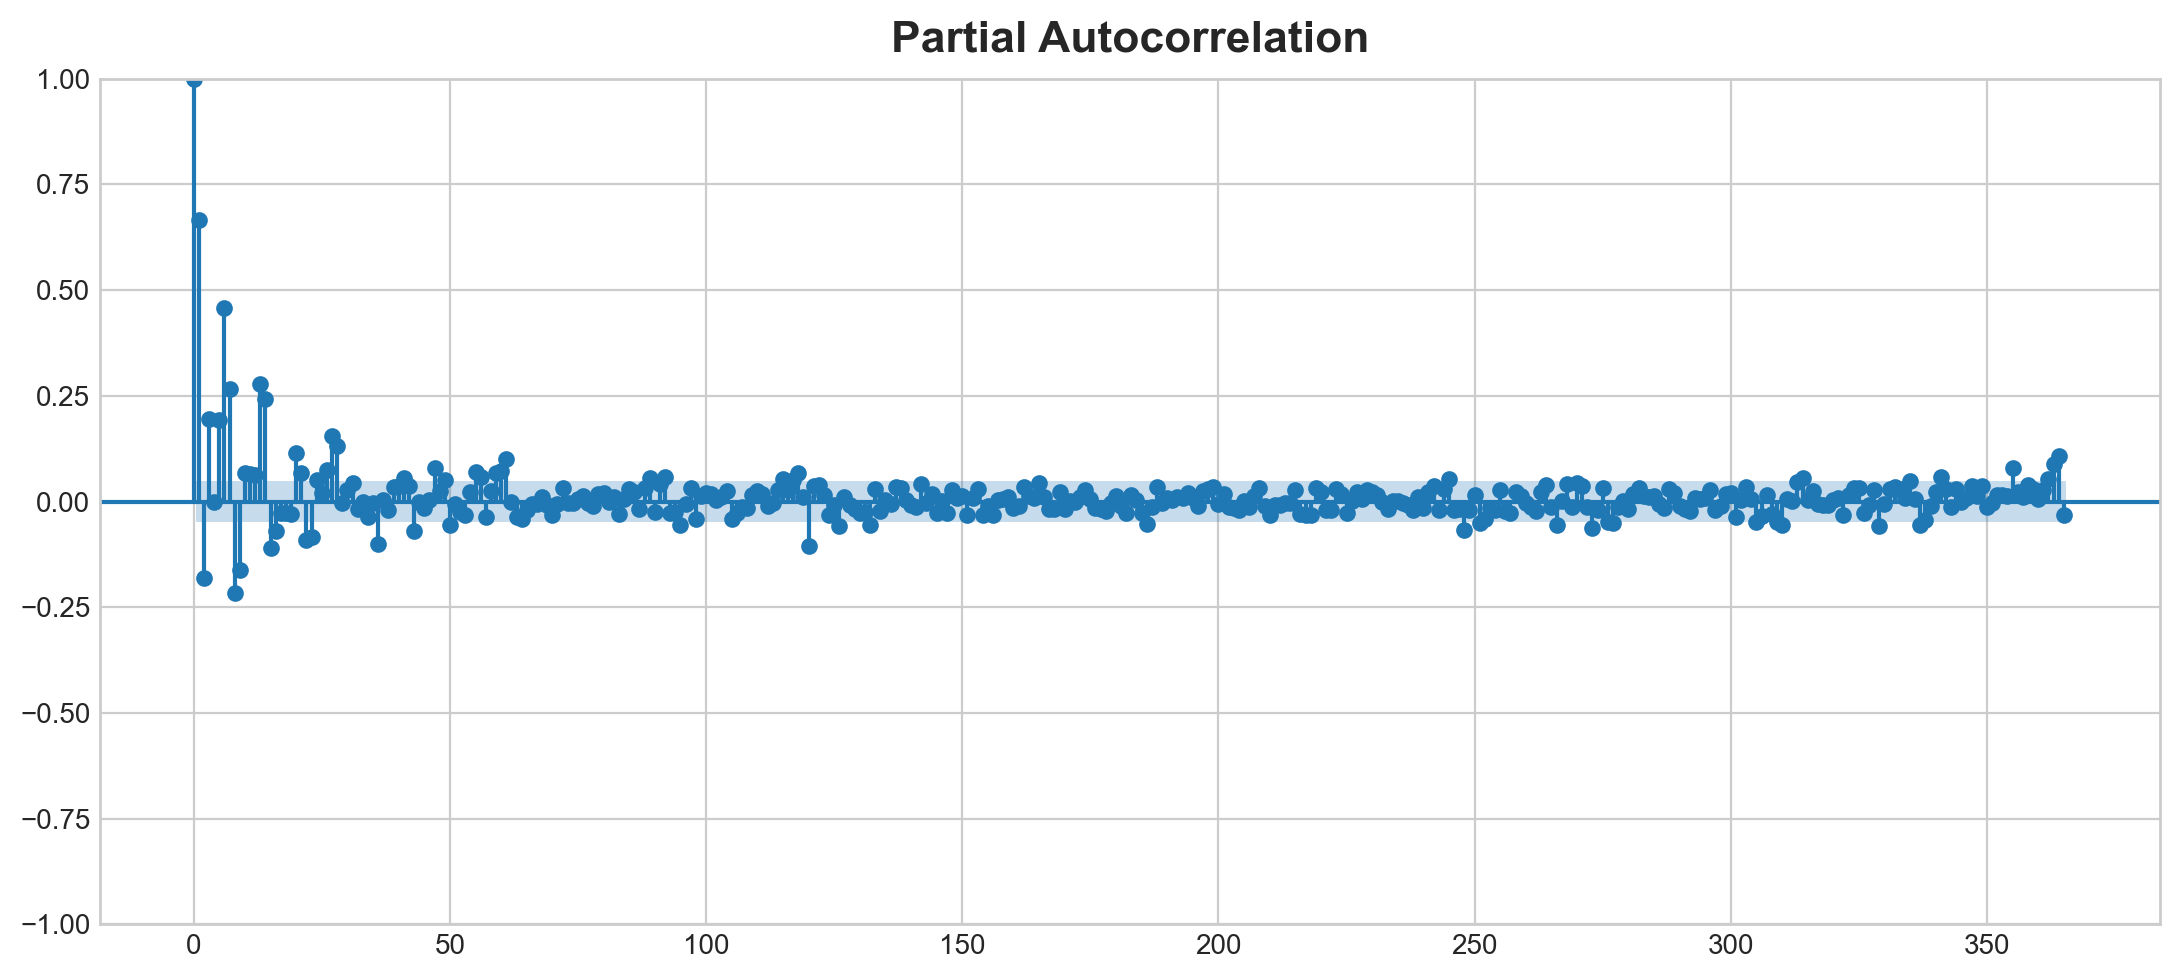

In [10]:
plot_pacf(avg_grocery_sales["sales"] , lags=365)
#partial autocorrelations suggest we can use lag 1-7 


In [189]:
test = df
for x in range(1,8):
    test["lag"+str(x)] = test["sales"].shift(x)

#test.head(5000).to_clipboard()

In [6]:
test = df 
grouped = test.groupby(level=['store_nbr','family'], as_index=False)
def create_lag_features(group, lags):
    for lag in lags:
        group[f'sales_lag_{lag}'] = group['sales'].shift(lag)
    return group
data_with_lags = grouped.apply(lambda x: create_lag_features(x,  range(1,15)))
data_with_lags.drop(columns=['sales_lag_4','sales_lag_8','sales_lag_9','sales_lag_10','sales_lag_11','sales_lag_12', 'sales_lag_13'], inplace=True)
data_with_lags.fillna(0, inplace=True)
data_with_lags

id  sales  onpromotion  month  \
     date       store_nbr family                                           
0    2013-01-01 1         AUTOMOTIVE        0    0.0            0      1   
     2013-01-02 1         AUTOMOTIVE     1782    2.0            0      1   
     2013-01-03 1         AUTOMOTIVE     3564    3.0            0      1   
     2013-01-04 1         AUTOMOTIVE     5346    3.0            0      1   
     2013-01-05 1         AUTOMOTIVE     7128    5.0            0      1   
...                                       ...    ...          ...    ...   
1781 2017-08-11 54        SEAFOOD     2993627    0.0            0      8   
     2017-08-12 54        SEAFOOD     2995409    1.0            1      8   
     2017-08-13 54        SEAFOOD     2997191    2.0            0      8   
     2017-08-14 54        SEAFOOD     2998973    0.0            0      8   
     2017-08-15 54        SEAFOOD     3000755    3.0            0      8   

                                      year  day_of_week  day_of_month  \
     date       store_nbr family                                        
0    2013-01-01 1         AUTOMOTIVE  2013            1             1   
     2013-01-02 1         AUTOMOTIVE  2013            2             2   
     2013-01-03 1         AUTOMOTIVE  2013            3             3   
     2013-01-04 1         AUTOMOTIVE  2013            4             4   
     2013-01-05 1         AUTOMOTIVE  2013            5             5   
...                                    ...          ...           ...   
1781 2017-08-11 54        SEAFOOD     2017            4            11   
     2017-08-12 54        SEAFOOD     2017            5            12   
     2017-08-13 54        SEAFOOD     2017            6            13   
     2017-08-14 54        SEAFOOD     2017            0            14   
     2017-08-15 54        SEAFOOD     2017            1            15   

                                      quarter  weekofyear  sales_lag_1  \
     date       store_nbr family                                         
0    2013-01-01 1         AUTOMOTIVE        1           1          0.0   
     2013-01-02 1         AUTOMOTIVE        1           1          0.0   
     2013-01-03 1         AUTOMOTIVE        1           1          2.0   
     2013-01-04 1         AUTOMOTIVE        1           1          3.0   
     2013-01-05 1         AUTOMOTIVE        1           1          3.0   
...                                       ...         ...          ...   
1781 2017-08-11 54        SEAFOOD           3          32          2.0   
     2017-08-12 54        SEAFOOD           3          32          0.0   
     2017-08-13 54        SEAFOOD           3          32          1.0   
     2017-08-14 54        SEAFOOD           3          33          2.0   
     2017-08-15 54        SEAFOOD           3          33          0.0   

                                      sales_lag_2  sales_lag_3  sales_lag_5  \
     date       store_nbr family                                              
0    2013-01-01 1         AUTOMOTIVE          0.0          0.0          0.0   
     2013-01-02 1         AUTOMOTIVE          0.0          0.0          0.0   
     2013-01-03 1         AUTOMOTIVE          0.0          0.0          0.0   
     2013-01-04 1         AUTOMOTIVE          2.0          0.0          0.0   
     2013-01-05 1         AUTOMOTIVE          3.0          2.0          0.0   
...                                           ...          ...          ...   
1781 2017-08-11 54        SEAFOOD             4.0         12.0          0.0   
     2017-08-12 54        SEAFOOD             2.0          4.0          0.0   
     2017-08-13 54        SEAFOOD             0.0          2.0         12.0   
     2017-08-14 54        SEAFOOD             1.0          0.0          4.0   
     2017-08-15 54        SEAFOOD             2.0          1.0          2.0   

                                      sales_lag_6  sales_lag_7  sales_lag_14  
     date       store_nbr family  

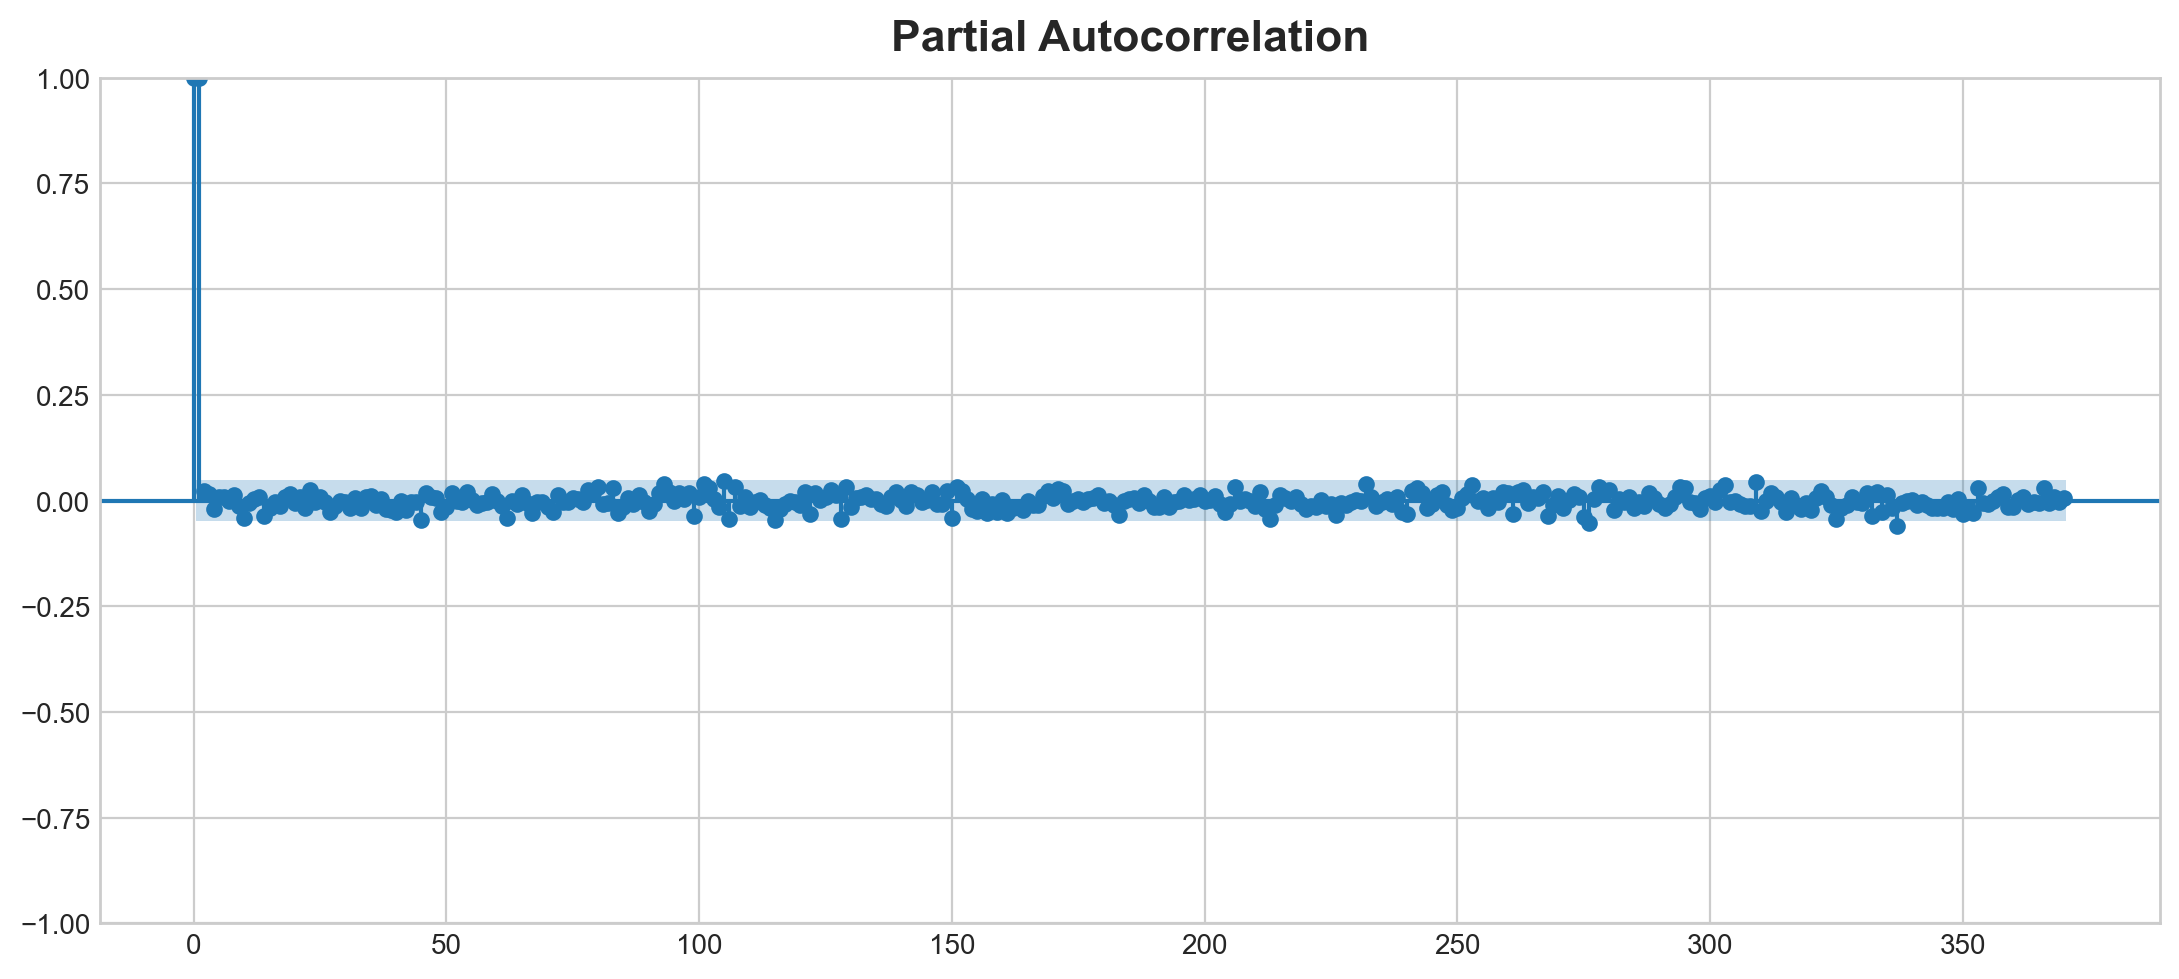

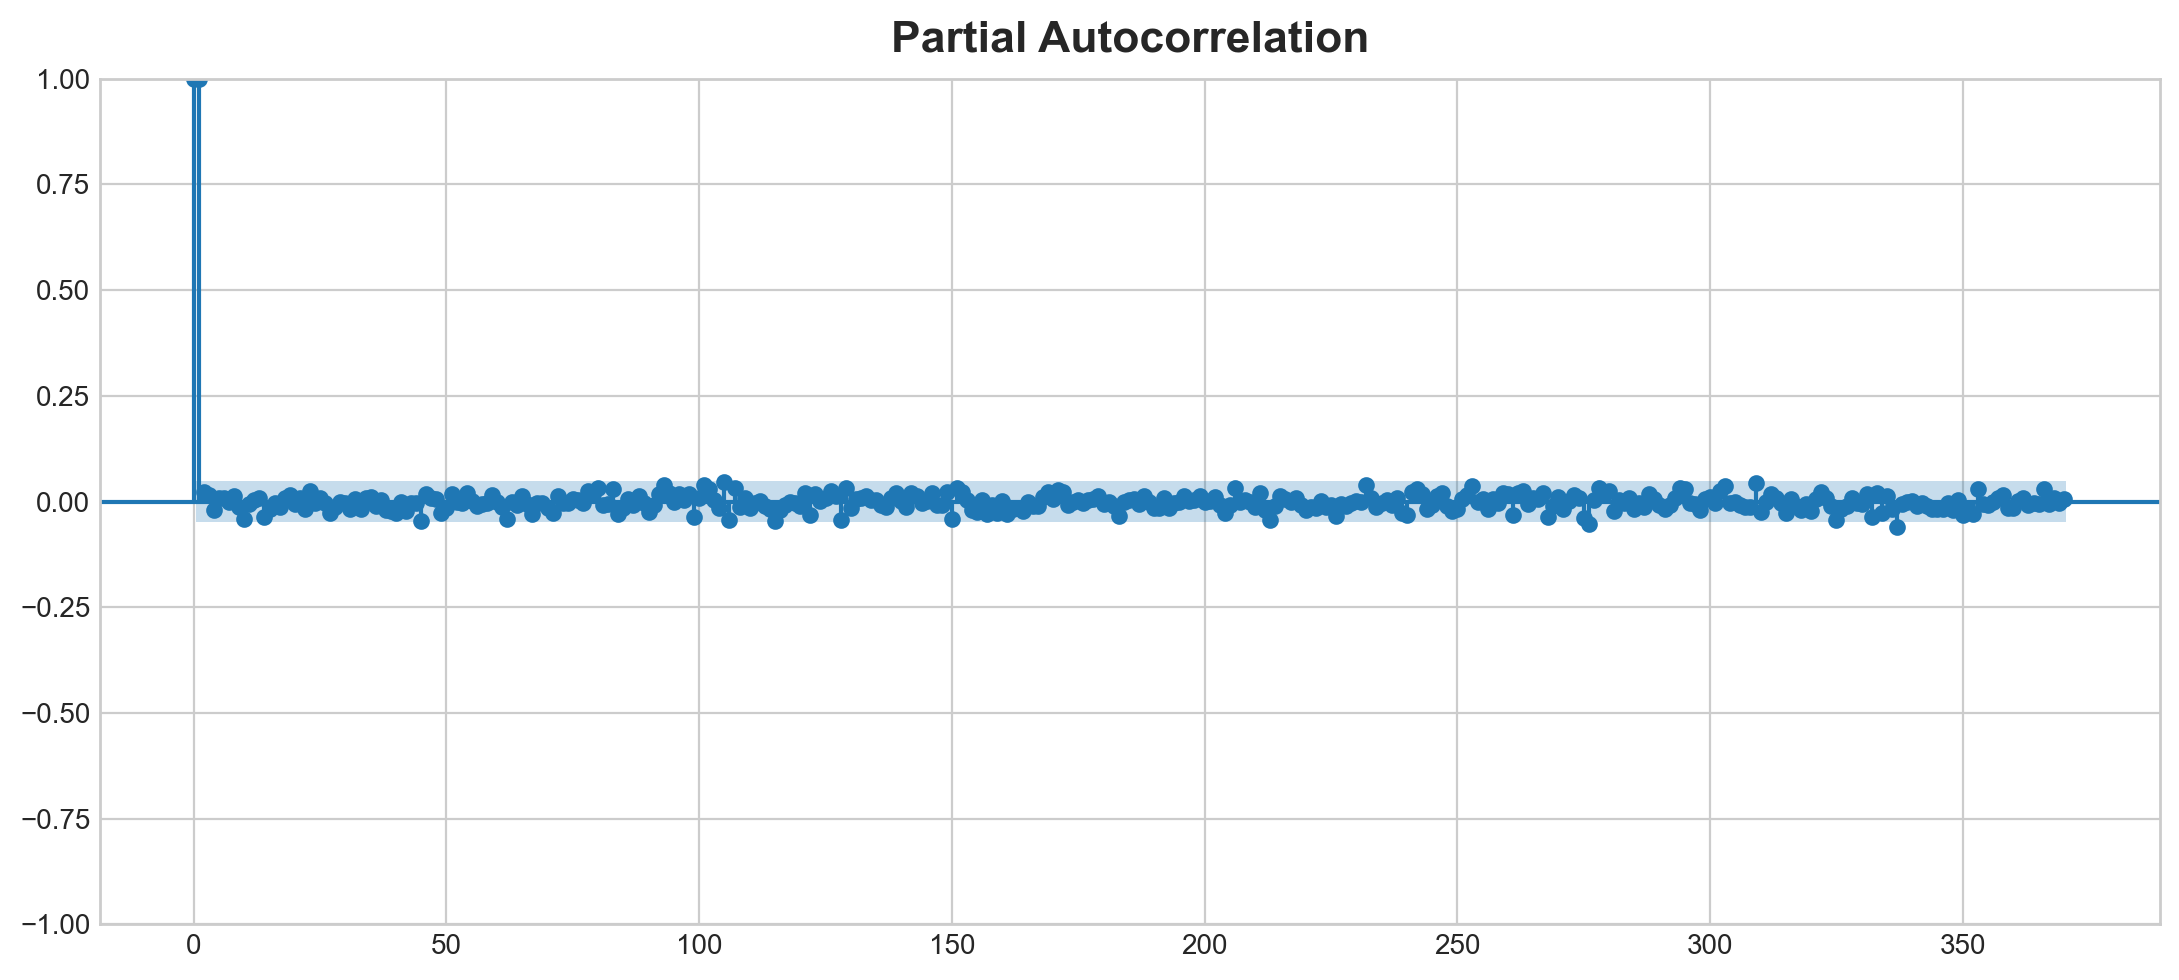

In [45]:
oil_df = pd.read_csv('oil_updated.csv')
oil_df['date'] = pd.to_datetime(oil_df['date'])
oil_df['dcoilwtico'].ffill(inplace=True)
plot_pacf(oil_df["dcoilwtico"] , lags=90)

In [43]:
#deal with outliers
def handle_outliers(data):
    condition = (data['family'] == 'GROCERY I') & (data['date'].dt.year == 2016) & (data['date'].dt.month == 4)
    data.loc[condition, 'sales'] = 4500
    return data
df = pd.read_csv('train.csv', parse_dates=['date'], dtype={
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
})
df['date'] = pd.to_datetime(df['date'])
df['sales'] = df['sales'].astype(np.int32)
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df = handle_outliers(df)

# df.query("family=='GROCERY I' and year==2016").describe()
# stddev = 3229 
# mean = 4367 
# print(mean+(3*stddev))
# df.query("family=='GROCERY I' and sales>14054 ")


In [44]:
df_plot = df.reset_index().set_index('family').loc['GROCERY I'].groupby(['date'])['sales'].mean().to_frame()
fig = pe.scatter(df_plot.reset_index(), x='date', y='sales', width=1200)
fig.show()

In [32]:
df_plot = df.reset_index().set_index('family').loc['BEVERAGES'].groupby(['date'])['sales'].mean().to_frame()
fig = pe.scatter(df_plot.reset_index(), x='date', y='sales', width=1200)
fig.show()

In [36]:
df_plot = df.reset_index().groupby(['date', 'family'])['sales'].mean().to_frame().reset_index()
fig = pe.scatter(df_plot.reset_index(), x='date', y='sales', width=1200, color='family')
fig.show()

id       date store_nbr     family  sales  onpromotion  year  \
2108184  2108184 2016-04-01        11  GROCERY I   8260           58  2016   
2108835  2108835 2016-04-01         3  BEVERAGES   8303           10  2016   
2108844  2108844 2016-04-01         3  GROCERY I   9019           32  2016   
2108862  2108862 2016-04-01         3    PRODUCE   8319            1  2016   
2109240  2109240 2016-04-01        40  GROCERY I   9173           57  2016   
...          ...        ...       ...        ...    ...          ...   ...   
2161206  2161206 2016-04-30        49  BEVERAGES   8487           28  2016   
2161215  2161215 2016-04-30        49  GROCERY I   9808           73  2016   
2161233  2161233 2016-04-30        49    PRODUCE   8586            1  2016   
2161281  2161281 2016-04-30        50  GROCERY I   9813           67  2016   
2161545  2161545 2016-04-30         9  GROCERY I  11326           56  2016   

         month  
2108184      4  
2108835      4  
2108844      4  
2108862      4  
2109240      4  
...        ...  
2161206      4  
2161215      4  
2161233      4  
2161281      4  
2161545      4  

[440 rows x 8 columns]